# DM-42228: fix failing tests


    FAILED tests/task/test_cutOutDonutsCwfsTask.py::TestCutOutDonutsCwfsTask::testPipeline - AssertionError: Masked images differ: image planes differ: maxDiff=564.8023071289062 at position (85, 126); value=556.9684448242188 vs. -7.833863735198975; maxDiff=1024 at position (77, 9); value=1024 vs. 0
    FAILED tests/task/test_cutOutDonutsCwfsTask.py::TestCutOutDonutsCwfsTask::testTaskRunNormal - AssertionError: Masked images differ: image planes differ: maxDiff=564.8023071289062 at position (85, 126); value=-7.833863735198975 vs. 556.9684448242188; maxDiff=1024 at position (77, 9); value=0 vs. 1024
    FAILED tests/task/test_cutOutDonutsScienceSensorTask.py::TestCutOutDonutsScienceSensorTask::testTaskRun - IndexError: index 0 is out of bounds for axis 0 with size 0
    
    
    
    =========================== short test summary info ============================
    FAILED tests/task/test_cutOutDonutsBase.py::TestCutOutDonutsBase::testCalculateFinalCentroid - ValueError: too many values to unpack (expected 4)
    FAILED tests/task/test_cutOutDonutsBase.py::TestCutOutDonutsBase::testCalculateSignalToNoise - AssertionError: Element counts were not equal:


# test_cutOutDonutsCwfsTask.py : why would it fail at all ?

I didn't modify it ... 

In [1]:
import os
from copy import copy

import lsst.utils.tests
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.cutOutDonutsCwfsTask import (
    CutOutDonutsCwfsTask,
    CutOutDonutsCwfsTaskConfig,
)
from lsst.ts.wep.utils import (
    DefocalType,
    getModulePath,
    runProgram,
    writeCleanUpRepoCmd,
    writePipetaskCmd,
)

In [2]:
moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run2"
# The visit number for the test data
visitNum = 4021123106000


In [3]:
# Point to the collections for the reference catalogs,
# the raw images and the camera model in the calib directory
# that comes from `butler write-curated-calibrations`.
collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
instrument = "lsst.obs.lsst.LsstCam"
cameraName = "LSSTCam"
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testCutoutsCwfsPipeline.yaml"
)

In [4]:
pipeCmd = writePipetaskCmd(
        repoDir,
        runName,
        instrument,
        collections,
        pipelineYaml=pipelineYaml,
    )
pipeCmd += f" -d 'exposure IN ({visitNum})'"

In [5]:
pipeCmd

"pipetask run -b /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/tests/testData/gen3TestRepo -i refcats/gen2,LSSTCam/calib,LSSTCam/raw/all --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run2 -p /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/tests/testData/pipelineConfigs/testCutoutsCwfsPipeline.yaml -d 'exposure IN (4021123106000)'"

The cmd contains:

    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing in ts_wep.
    description: wep basic processing test pipeline
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: "postISRCCD"
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
      generateDonutCatalogWcsTask:
        class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
        config:
          donutSelector.unblendedSeparation: 1
      cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
        config:
          # And here we specify the configuration settings originally defined in
          # CutOutDonutsCwfsTaskConfig.
          # Test CWFS pipeline works when specifying instrument parameters.
          donutStampSize: 160
          initialCutoutPadding: 40


Need to change `doVariance` to `True` rather than `False`. 

`setUp`: 

In [6]:
config = CutOutDonutsCwfsTaskConfig()
task = CutOutDonutsCwfsTask(config=config)

butler = dafButler.Butler(repoDir)
registry = butler.registry

dataIdExtra = {
    "instrument": "LSSTCam",
    "detector": 191,
    "exposure": visitNum,
    "visit": visitNum,
}
dataIdIntra = {
    "instrument": "LSSTCam",
    "detector": 192,
    "exposure": visitNum,
    "visit": visitNum,
}

testRunName = "testTaskRun"
collectionsList = list(registry.queryCollections())

In [7]:
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName]
)
exposureIntra =butler.get(
    "postISRCCD", dataId=dataIdIntra, collections=[runName]
)
# Get the donut catalogs for each detector
donutCatalogExtra = butler.get(
    "donutCatalog", dataId=dataIdExtra, collections=[runName]
)
donutCatalogIntra = butler.get(
    "donutCatalog", dataId=dataIdIntra, collections=[runName]
)
# Get the camera from the butler
camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections="LSSTCam/calib/unbounded",
)

Parts of `testTaskRunNormal`: 

In [31]:
donutCatalogExtra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,6.263161,-0.021515,2819.073188,1402.347521,3.630781e+06,[],[]
1,6.263451,-0.021225,2519.161622,1102.386391,3.630781e+06,[],[]


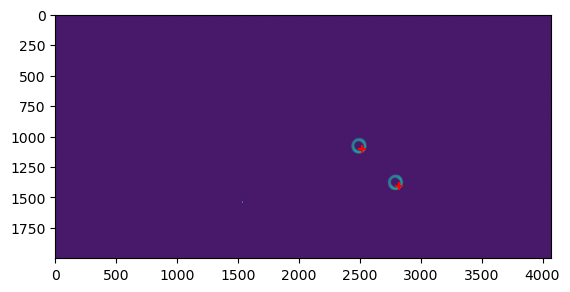

In [33]:
plt.imshow(exposureExtra.image.array, vmax=800)
plt.scatter(donutCatalogExtra['centroid_x'], donutCatalogExtra['centroid_y'],c='r',marker='+')

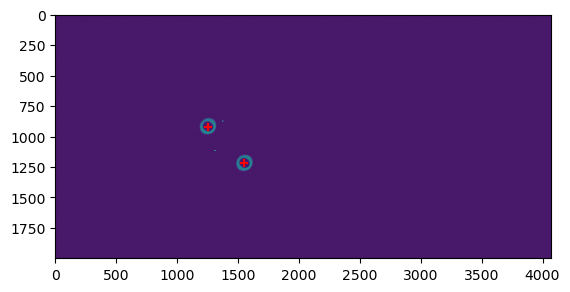

In [34]:
plt.imshow(exposureIntra.image.array, vmax=800)
plt.scatter(donutCatalogIntra['centroid_x'], donutCatalogIntra['centroid_y'],c='r',marker='+')

The positions in the donut catalog are correct. Ok - below the positions are the other way round! 

In [35]:
# Test normal behavior
taskOut2 = task.run(
    [copy(exposureExtra), copy(exposureIntra)],
    [donutCatalogExtra, donutCatalogIntra],
    camera,
)

In [8]:
# Test normal behavior
taskOut = task.run(
    [copy(exposureIntra), copy(exposureExtra)],
    [donutCatalogExtra, donutCatalogIntra],
    camera,
)

testExtraStamps = task.cutOutStamps(
    exposureExtra, donutCatalogExtra, DefocalType.Extra, camera.getName()
)
testIntraStamps = task.cutOutStamps(
    exposureIntra, donutCatalogIntra, DefocalType.Intra, camera.getName()
)

In [36]:
len(taskOut2.donutStampsExtra)

2

In [12]:
len(taskOut.donutStampsExtra)

2

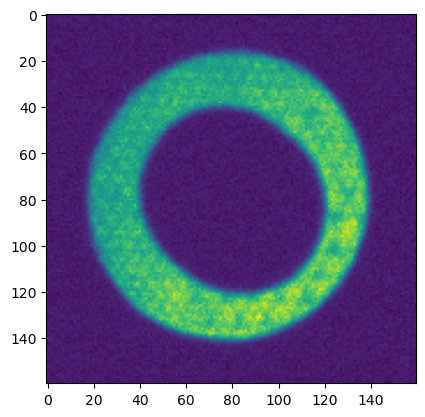

In [39]:
import matplotlib.pyplot as plt
plt.imshow(taskOut2.donutStampsExtra[1].stamp_im.image.array)

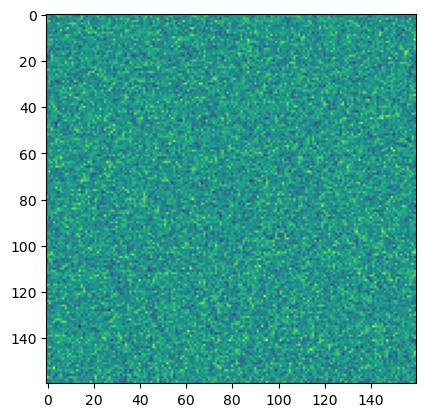

In [22]:
import matplotlib.pyplot as plt
plt.imshow(taskOut.donutStampsIntra[0].stamp_im.image.array)

why are all these stamps empty?  

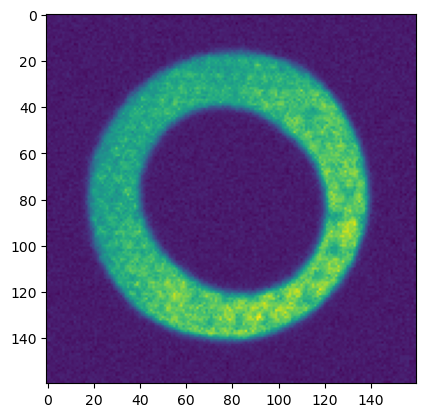

In [26]:
plt.imshow(testExtraStamps[1].stamp_im.image.array)

In [40]:
from lsst.ts.wep.task import (
    CalcZernikesTask,
    CalcZernikesTaskConfig,
    CombineZernikesMeanTask,
    CombineZernikesSigmaClipTask,
)
config = CalcZernikesTaskConfig()
calcTask = CalcZernikesTask(config=config, name="Base Task")


In [41]:
struct = calcTask.estimateZernikes.run(
            donutStampsIntra, donutStampsExtra
        ) 

NameError: name 'donutStampsIntra' is not defined